# Technology of Blockchain : Application of GARCH model to forecast the volatility of Bitcoin

In finance, volatility is a statistical measure of the dispersion of asset returns over time. It is often calculated as the standard deviation or variance of price returns. In this course, we will use the term "volatility" to describe either standard deviation or variance. Volatility describes the uncertainties surrounding the potential evolution of financial asset prices. It is an essential concept, widely used in risk management, portfolio optimization and other areas. It is also one of the most active areas of research in empirical finance and time series analysis. In general, the higher the volatility, the riskier a financial asset.

The GARCH model deals with stationary (mean around 0 and variance constant over time) and non-stationary variables.

The GARCH model embeds 3 concepts:
* **Autoregressive :** The current value can be expressed as a function of previous values, i.e. they are correlated. 
* **Conditional:** This indicates that the variance is based on past errors. 
* **Heteroscedasticity:** This implies that the series displays an unusual variance (variable variance).
GARCH models can be understood intuitively. Firstly, the model is autoregressive in nature. It attempts to estimate volatility at time $t$ on the basis of information known at time $t-1$. Secondly, it estimates volatility as a weighted average of past information.

For a GARCH(1,1) process to be realistic, two conditions must be met: 
* Firstly, all parameters $\omega$, $\alpha$, $\beta$ and must be non-negative. This ensures that the variance cannot be negative. 
* Secondly, $\alpha+\beta<1$ means that the model estimates are mean reversions of the long-term variance.
* The long-term variance is equal to $\omega/(1-\alpha-\beta)$.

The empirical rules for model parameters is that the larger the parameter $\alpha$, the greater the immediate impact of shocks. Here, shocks are expressed as residuals or prediction errors. If fixed, the larger the $\beta$ is, the longer the duration of the impact, i.e. periods of high or low volatility tend to persist.

### GARCH(1,1) equation 

$$GARCH(1,1): \sigma_{t}^{2} = \omega+\alpha\epsilon_{t-1}^{2}+\beta\sigma_{t-1}^{2}$$

### GARCH(p,q) equation

$$\text{GARCH}(p, q) : \sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2$$

* $\sigma_t^2$ represents the conditioal variance at time $t$
* $\omega$ is the constant or intercept term
* $\alpha_i$ are the parameters for the autoregressive conditional variance terms, where $i$ range from $1$ to $p$
* $\epsilon_{t-i}^2$ represents the squared returns at time $t-i$
* $\beta_j$ are the parameters for the conditional variance lag terms, where $j$ ranges from $1$ to $q$
* $\sigma_{t-j}^2$ represents the conditional variance at time $t-j$


Intuitively, the GARCH variance forecast can be interpreted as a weighted average of three different variance forecasts. One is a constant variance that corresponds to the long-term average. The second is the new information that was not available when the previous forecast was made. The third is the forecast made in the previous period. The weights of these three forecasts determine how quickly the variance changes with new information, and how quickly it returns to its long-term average.

In expectation, $X_t^2$ is the marginal variance of the log returns. Why is this the case? Recall the relationship between variance and expected value of $var(X) = E[X^2] - E[X]^2$. We know that $E[X_t] = 0$ because expected returns are trivially 0 due to the efficient market hypothesis. Thus, E[Xₜ]² = 0, and we are left with the marginal variance $\sigma = E[X^2]$, which is constant and does not depend on t.

We build on the concept of constant marginal variance to incorporate heteroskedasticity by modeling the volatility at time $t$ ($\sigma_t^2$), which is the conditional variance of the time series and is directly influenced by the squared log return $X_t^2$.

#### Note:

It's important to note that GARCH model can only be applied to time series that do not have any trends or seasonal effects, i.e. that has no (evident) serially correlation. Otherwise, the series have to be a white noise (mean close to 0 and constant variance over the time)

## Import Libs

In [1]:
#!pip install arch
#!pip install pmdarim

In [2]:
# basic libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# stats libs
from statsmodels.tsa.stattools import adfuller
from pmdarima.model_selection import train_test_split
from arch import arch_model
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2, jarque_bera

import warnings
warnings.filterwarnings('ignore')

## Import the data

The data corresponds to bitcoin price between 2014-11-28 and 2022-03-01 and 

In [3]:
data_bitcoin_daily = pd.read_csv("BTC-Daily.csv", parse_dates=["date"], index_col=["date"])
data_bitcoin_daily

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01,1646092800,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06
2022-02-28,1646006400,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08
2022-02-27,1645920000,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
2022-02-26,1645833600,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2022-02-25,1645747200,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
...,...,...,...,...,...,...,...,...
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03


### Re-ordering the index of the dataframe in descending order

In [4]:
data_bitcoin_daily = data_bitcoin_daily.sort_index()
data_bitcoin_daily

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2014-11-28,1417132800,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
2022-02-26,1645833600,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2022-02-27,1645920000,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07


### Resampling the time series by month

In [5]:
data_bitcoin_monthly = data_bitcoin_daily.resample('M').sum()
data_bitcoin_monthly

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2014-11-30,4251657600,BTC/USDBTC/USDBTC/USD,1116.58,1149.93,1106.14,1126.34,7.112602e+06,1.890867e+04
2014-12-31,43979328000,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,10654.34,10807.73,10430.08,10596.22,8.959470e+07,2.647025e+05
2015-01-31,44062358400,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,7779.24,8079.62,7389.28,7678.82,1.683872e+08,7.301830e+05
2015-02-28,39869625600,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,6524.35,6716.07,6354.05,6559.79,5.338739e+07,2.275957e+05
2015-03-31,44220384000,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,8338.52,8502.11,8110.14,8326.50,7.613728e+07,2.843678e+05
...,...,...,...,...,...,...,...,...
2021-11-30,49109328000,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,1825425.30,1863195.09,1774296.21,1821164.82,7.220080e+04,4.342089e+09
2021-12-31,50827996800,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,1539882.72,1574639.21,1487039.17,1529178.82,7.189638e+04,3.556527e+09
2022-01-31,50911027200,BTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/USDBTC/...,1281904.34,1307171.49,1240243.49,1274467.34,7.187726e+04,2.865807e+09


### Plot the monthly price trend

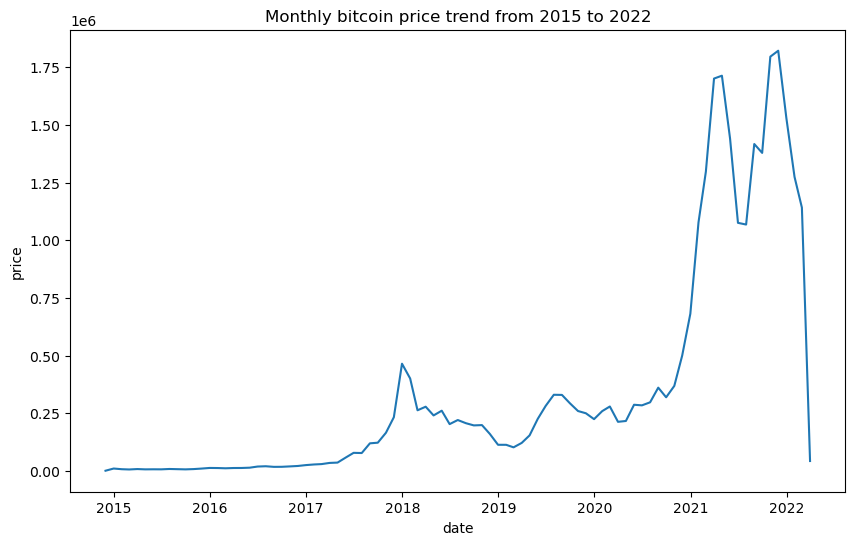

In [6]:
plt.figure(figsize=(10,6))
plt.plot(data_bitcoin_monthly.index, data_bitcoin_monthly.close)
plt.xlabel("date")
plt.ylabel("price")
plt.title("Monthly bitcoin price trend from 2015 to 2022")
plt.show()

### Compute the returns

We can see that the previous the trend price of the Bitcoin not seems to be a white noise. Let's take to convert this time series to a white noise. A convenient to model financial assets is to look at log-returns.

$r_t = log(\frac{P_t}{P_{t-1}}) = log(P_t) - log(P_{t-1})$ 

In [7]:
data_bitcoin_daily['log_return'] = np.log(data_bitcoin_daily['close'] / data_bitcoin_daily['close'].shift(1))
data_bitcoin_daily

,unix,symbol,open,high,low,close,Volume BTC,Volume USD,log_return
date,,,,,,,,,
2014-11-28,1417132800,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03,NaN
2014-11-29,1417219200,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03,0.001169
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03,-0.009013
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03,0.013436
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03,0.002270
...,...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07,0.022028
2022-02-26,1645833600,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07,-0.002168
2022-02-27,1645920000,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07,-0.037319


In [8]:
data_bitcoin_daily.dropna(inplace=True) # drop NaN created created by the previous operation (lag-1)

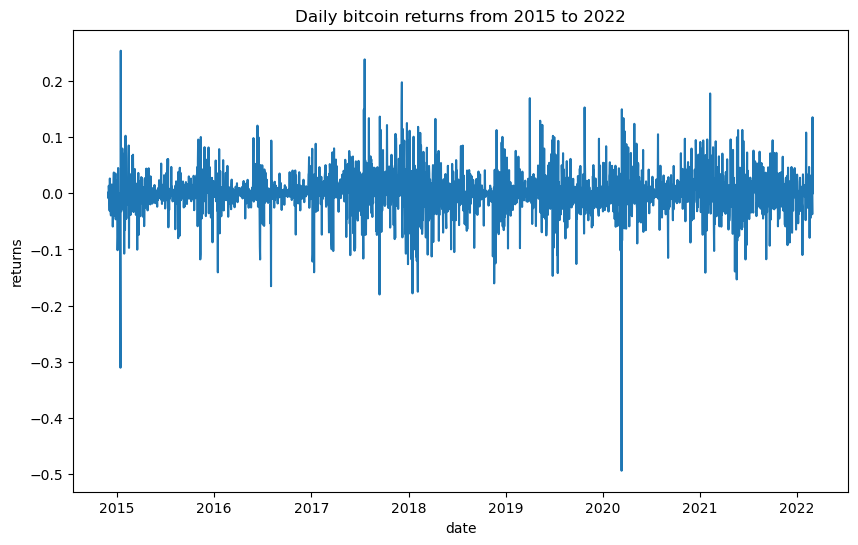

In [9]:
plt.figure(figsize=(10,6))
plt.plot(data_bitcoin_daily.index, data_bitcoin_daily.log_return)
plt.xlabel("date")
plt.ylabel("returns")
plt.title("Daily bitcoin returns from 2015 to 2022")
plt.show()

### Check if the time series of returns is stationary with the `ADF test`

Let's consider the following hypothesis:
* **H0:** there is a unit root (i.e. non stationarity)

Note: the p-value is the probability to wrongly reject H0

In [10]:
result_adf = adfuller(data_bitcoin_daily.log_return, regression='n')  # 'c' for a constant term

# Extract ADF test statistics and p-value
p_value = result_adf[1]
if p_value <= 0.05:
    print("Reject the null hypothesis. The time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The time series may be non-stationary.")

Reject the null hypothesis. The time series is likely stationary.


### Autocorrelation (ACF) and Partial Autocorrelation (PACF) graph

We want to visualize how previous returns with different lags are correlated with one another.
Due tu the properties of stationarity, the correlation and covariance at different points in time should be the same for the same gap — also know as lag $h$ — regardless of the exact point in time t. That is, ACF and PACF should be constant across the same lag in time and should depend only on the lag h and not directly on $t$.

While ACF and PACF can be used to determine to have good estimation of the best orders of p and q of the GARCH

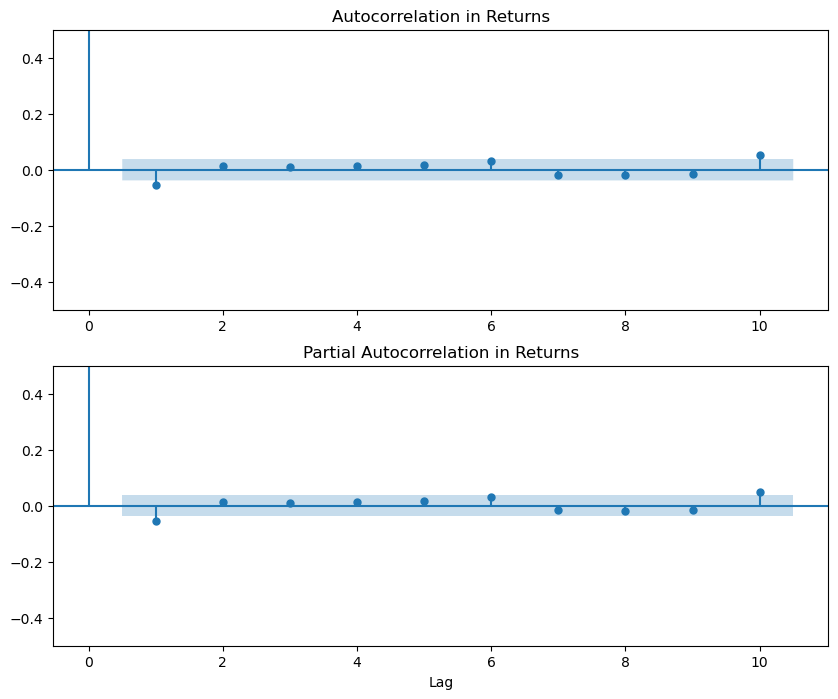

In [11]:
# Plot ACF and PACF
diff_ts = data_bitcoin_daily['log_return'].iloc[1:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

The above ACF and PACF plots do not indicate that there are GARCH effects present. In particular, we would want indication to believe the series in not independent, which would visually be seen as lags for which the ACF and PACF values are outside the blue area. This would imply a significant difference in the ACF or PACF from 0 and would allow us to model the ARCH effects.

To ensure that this is an independent series, or rather to test that it is not, we remember that an independent series is one in which transformations of the series are themselves independent. Thus, we can repeat the process above using the squared returns or the absolute returns. We utilize the absolute returns, as this is generally done in financial data to diminish the effects of outliers.

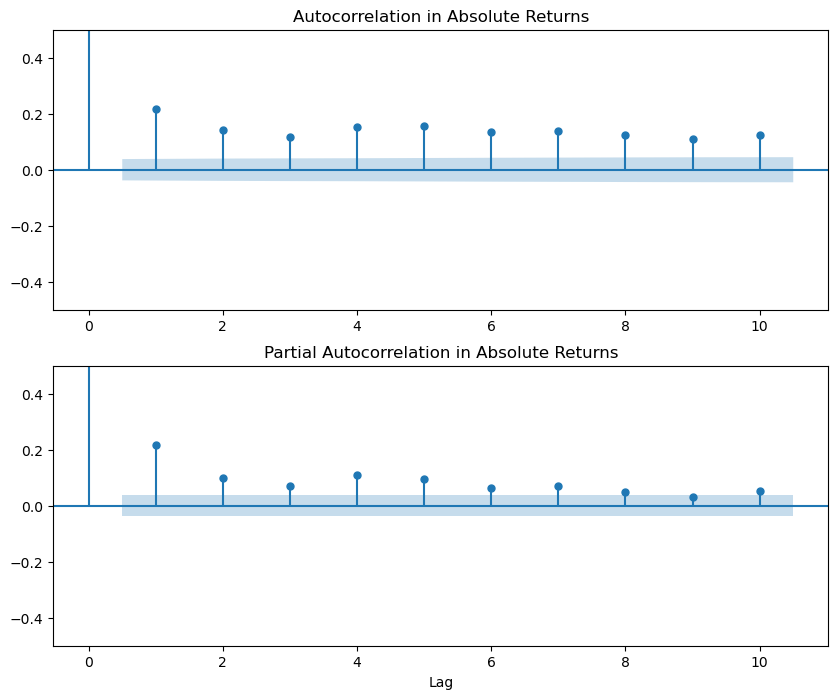

In [12]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")  

plt.show();

After the above transformation to absolute returns, there is now a pattern indicative of GARCH effects being present. In the PACF, there is not a big drop until about lag 1, which might indicate that we should have an order of P,Q up to 1. Indeed, the PACF and ACF cut off after the lag 1. Hence we have guess that the best parameters are GARCH(1,1)

### Perform a McLeod-Li Test

We will more formally test these effects using the McLeod-Li test for GARCH effects.

The McLeod-Li test proposes the following null and alternative hypotheses to test for white noise behavior in the residuals of the series:

* **$H_0$:** there are no ARCH effects in the time series

* **$H_1$:** there are ARCH effects in the time series

We thus first fit a model of GARCH(1,1) and then apply the McLeod-Li test to the residuals. The result of the test is a p-value < 0.005 and thus we can reject $H_0$conclude that there are GARCH effects in the time series.

In [13]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

if p_value < 0.05:
    print("There are GARCH effect")

McLeod-Li test statistic:  1609304.63819813
p-value:  0.0
There are GARCH effect


### Split our dataset in training and train test

In [14]:
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

### Indentifying the best parameters of GARCH model 

In [15]:
# Define a range of GARCH model orders to test
p_values = [1, 2, 3]  # Order of autoregressive term
q_values = [1, 2, 3]  # Order of moving average term

# Initialize an empty list to store DataFrames
results_list = []

for p, q in product(p_values, q_values):
    if p == 0 and q == 0:
        continue

    model = arch_model(abs_returns, vol='GARCH', p=p, q=q, mean='zero')
    results = model.fit()
    aic = results.aic
    bic = results.bic

    # Create a DataFrame for the current model and results
    result_df = pd.DataFrame({"p": [p], "q": [q], "AIC": [aic], "BIC": [bic]})
    
    results_list.append(result_df)

# Concatenate all the DataFrames in the results_list into one DataFrame
results_df = pd.concat(results_list, ignore_index=True)
results_df

Iteration:      1,   Func. Count:      4,   Neg. LLF: -4970.754657537982
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4970.754636608015
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8660.522906263566
Iteration:      2,   Func. Count:     14,   Neg. LLF: -4858.122276194105
Iteration:      3,   Func. Count:     20,   Neg. LLF: -4497.833643766585
Iteration:      4,   Func. Count:     26,   Neg. LLF: -4832.158594136075
Iteration:      5,   Func. Count:     32,   Neg. LLF: -602.4944508887264
Iteration:      6,   Func. Count:     39,   Neg. LLF: -4981.527277722231
Iteration:      7,   Func. Count:     44,   Neg. LLF: -4968.50290546102
Iteration:      8,   Func. Count:     50,   Neg. LLF: -4264.646480697067
Iteration:      9,   Func. Count:     56,   Neg. LLF: -4547.4107688714685
Iteration:     10,   Func. Count:     62,   Neg. LLF: -4985.6743

,p,q,AIC,BIC
0,1,1,-9935.509273,-9917.863461
1,1,2,-9965.570499,-9942.042749
2,1,3,-10005.175026,-9975.765339
3,2,1,-9906.334834,-9882.807084
4,2,2,-9952.936133,-9923.526446
5,2,3,-10004.447733,-9969.156108
6,3,1,-9963.518885,-9934.109198
7,3,2,-9935.811596,-9900.519971
8,3,3,-10002.447737,-9961.274175


### Find the best parameters

In [16]:
# Find the best AIC and BIC values
best_aic_row = results_df.loc[results_df["AIC"].idxmin()]
best_bic_row = results_df.loc[results_df["BIC"].idxmin()]

print("AIC Results:")
print(best_aic_row)
print("\nBIC Results:")
print(best_bic_row)

AIC Results:
p          1.000000
q          3.000000
AIC   -10005.175026
BIC    -9975.765339
Name: 2, dtype: float64

BIC Results:
p          1.000000
q          3.000000
AIC   -10005.175026
BIC    -9975.765339
Name: 2, dtype: float64


AIC criterion is more suitable for forecasting. Hence we will choose the following parameters:
* **`p` = 1**
* **`q` = 3**

### Find the best distribution parameters for GARCH

Price-return distribution curves often have wide tails. In other words, the probability of observing very large returns, whether positive or negative, is higher than in the case of a normal distribution.

Returns distribution also tend to exhibit asymmetry. Negative asymmetry means that the left-hand tail of the distribution curve is longer, so that the mass of the distribution is on the right-hand side of the figure. Conversely, positive asymmetry means that the right-hand tail is longer, and the mass of the distribution is concentrated on the left.

Let's to select which distribution our model fit the best:

* normal distribution
* skew t-distribution (t-student asymetric)

Iteration:      1,   Func. Count:      7,   Neg. LLF: -5293.6059119613055
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5293.60591235361
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -5293.605895642162
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5293.60591235361
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1


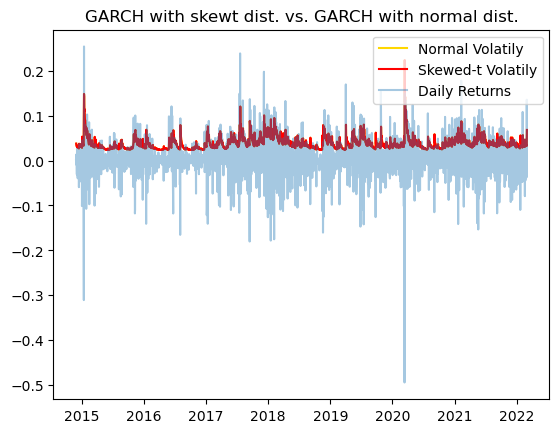

In [17]:
garch_normal = arch_model(abs_returns, vol='GARCH', p=1, q=3, mean='zero', dist='t')
garch_normal_result = garch_normal.fit()

# get model estimated volatility
arch_normal_vol = garch_normal_result.conditional_volatility


garch_skewt = arch_model(abs_returns, vol='GARCH', p=1, q=3, mean='zero', dist='skewt')
garch_skewt_result = garch_skewt.fit()

# get model estimated volatility
arch_skewt_vol = garch_skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(arch_normal_vol, color='gold', label='Normal Volatily')
plt.plot(arch_skewt_vol, color='red', label='Skewed-t Volatily')
plt.plot(data_bitcoin_daily['log_return'], label='Daily Returns' ,alpha=0.4)
plt.title("GARCH with skewt dist. vs. GARCH with normal dist.")
plt.legend(loc = 'upper right')
plt.show()

As we can see, with the assumption of an asymmetrical t-Student distribution, the GARCH model estimate is more in line with actual observations.

Hence, we will chose the following parameter:
* **`dist` = skewt**

### GARCH vs. GJR GARCH

Iteration:      1,   Func. Count:      9,   Neg. LLF: 62157.25283631004
Iteration:      2,   Func. Count:     23,   Neg. LLF: 13462.842698074463
Iteration:      3,   Func. Count:     33,   Neg. LLF: 32619.493393207187
Iteration:      4,   Func. Count:     42,   Neg. LLF: 32289.949209293725
Iteration:      5,   Func. Count:     52,   Neg. LLF: 10432.071897399483
Iteration:      6,   Func. Count:     61,   Neg. LLF: -3645.02776518713
Iteration:      7,   Func. Count:     70,   Neg. LLF: 10148.845169786915
Iteration:      8,   Func. Count:     79,   Neg. LLF: -4395.660343353929
Iteration:      9,   Func. Count:     88,   Neg. LLF: -4210.131018077665
Iteration:     10,   Func. Count:     97,   Neg. LLF: -4560.353884183471
Iteration:     11,   Func. Count:    106,   Neg. LLF: -5674.730814521808
Iteration:     12,   Func. Count:    114,   Neg. LLF: -5612.231130636079
Iteration:     13,   Func. Count:    123,   Neg. LLF: -5572.618767071256
Iteration:     14,   Func. Count:    132,   Neg. LLF:

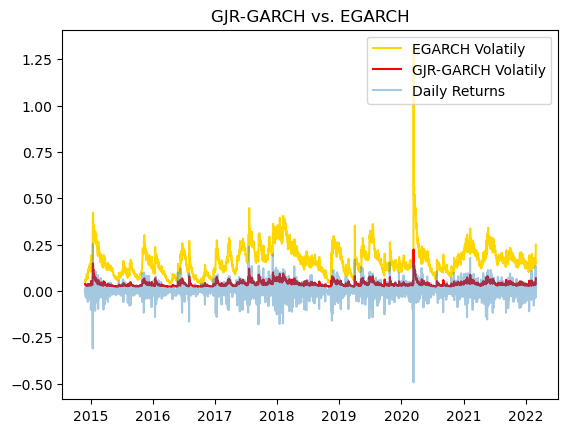

In [18]:
egarch = arch_model(abs_returns, vol='EGARCH', p=1, q=3, mean='zero', dist='skewt')
egarch_result = egarch.fit()
print(egarch_result.summary())

# get model estimated volatility
egarch_vol = egarch_result.conditional_volatility


garch = arch_model(abs_returns, vol='GARCH', p=1, q=3, mean='zero', dist='skewt')
garch_result = garch.fit()
print(garch_result.summary())

# get model estimated volatility
garch_vol = garch_result.conditional_volatility

# Plot model fitting results
plt.plot(egarch_vol, color='gold', label='EGARCH Volatily')
plt.plot(garch_vol, color='red', label='GJR-GARCH Volatily')
plt.plot(data_bitcoin_daily['log_return'], label='Daily Returns' ,alpha=0.4)
plt.title("GJR-GARCH vs. EGARCH")
plt.legend(loc = 'upper right')

Overall, the GJR-GARCH and EGARCH models fitted the real data well. Comparatively, the GJR-GARCH model is more conservative in estimating volatility when applied to the bitcoin dataset. 

In [19]:
print('AIC of EGARCH model:', egarch_result.aic)
print('BIC of EGARCH model:', egarch_result.bic)
print('AIC of GJR-GARCH model:', garch_result.aic)
print('BIC of GJR-GARCH model:', garch_result.aic)

AIC of EGARCH model: -11566.570080469035
BIC of EGARCH model: -11525.39651804413
AIC of GJR-GARCH model: -10573.21182470722
BIC of GJR-GARCH model: -10573.21182470722


AIC and BIC are better for the GJR-GARCH model. So the GJR-GARCH model is relatively better than the EGARCH model.

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                        log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                5293.61
Distribution:      Standardized Skew Student's t   AIC:                          -10573.2
Method:                       Maximum Likelihood   BIC:                          -10532.0
                                                   No. Observations:                 2649
Date:                           Wed, Oct 25 2023   Df Residuals:                     2649
Time:                                   21:34:32   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

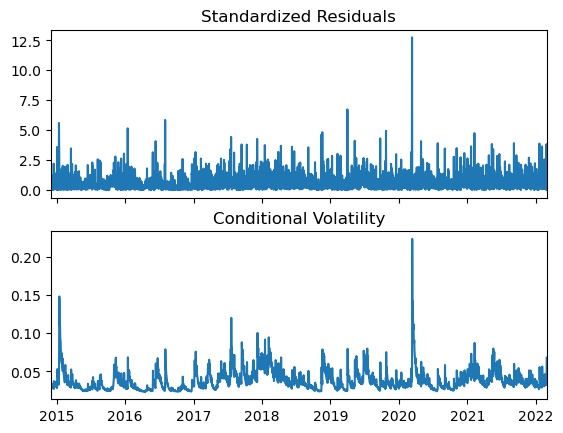

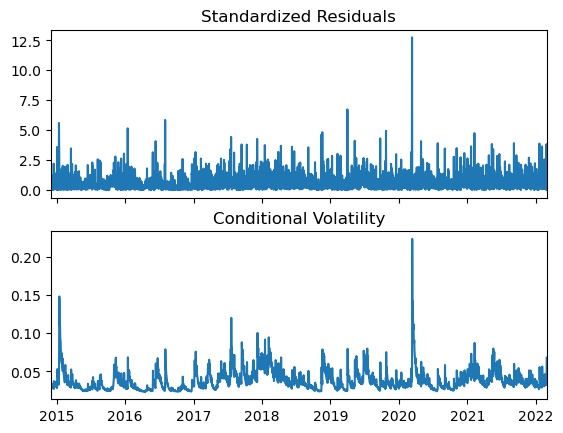

In [20]:
print(garch_result.summary())
garch_result.plot()

### Forecasting volatility beyond the dataset with GARCH

In [21]:
garch = arch_model(abs_returns[5:], vol='GARCH', p=1, q=3, mean='zero', dist='skewt')
garch_result = garch.fit()

# Make 5-period ahead forecast
garch_forecast = garch_result.forecast(horizon = 5)
# Print the forecast variance
print(garch_forecast.variance[-1:])

Iteration:      1,   Func. Count:      8,   Neg. LLF: -5280.577123699565
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5280.577140382355
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
                 h.1       h.2       h.3       h.4     h.5
date                                                      
2022-03-01  0.001775  0.002303  0.002655  0.002264  0.0023


### Focus on the COVID period

#### Split our dataset in train and test set

In [22]:
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

In [23]:
garch = arch_model(y_train, vol='GARCH', p=1, q=3, mean='zero', dist='skewt')
garch_result = garch.fit()
garch_result.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 116268.90115050659
Iteration:      2,   Func. Count:     18,   Neg. LLF: 35392.52048799333
Iteration:      3,   Func. Count:     27,   Neg. LLF: 19357.412387118937
Iteration:      4,   Func. Count:     37,   Neg. LLF: -2466.7355146788796
Iteration:      5,   Func. Count:     47,   Neg. LLF: 45317.334786689884
Iteration:      6,   Func. Count:     56,   Neg. LLF: 495.5253944748955
Iteration:      7,   Func. Count:     69,   Neg. LLF: -3516.045654446971
Iteration:      8,   Func. Count:     79,   Neg. LLF: 73796.44324720955
Iteration:      9,   Func. Count:     88,   Neg. LLF: -3015.9466139145543
Iteration:     10,   Func. Count:     96,   Neg. LLF: -4464.373555392078
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4464.373555643481
            Iterations: 14
            Function evaluations: 96
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Zero Mean - GARCH Model Results                             
=========================================================================================
Dep. Variable:                        log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                4464.37
Distribution:      Standardized Skew Student's t   AIC:                          -8914.75
Method:                       Maximum Likelihood   BIC:                          -8875.14
                                                   No. Observations:                 2119
Date:                           Wed, Oct 25 2023   Df Residuals:                     2119
Time:                                   21:34:33   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0688e-04  8.359e-05      2.475  1.332e-02 [4.305e-05,3.707e-04]
alpha[1]       0.3734  2.670e-02     13.984  1.943e-44     [  0.321,  0.426]
beta[1]        0.1397  8.637e-02      1.617      0.106  [-2.960e-02,  0.309]
beta[2]        0.1397      0.109      1.280      0.201  [-7.426e-02,  0.354]
beta[3]        0.2366  7.814e-02      3.028  2.459e-03   [8.348e-02,  0.390]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            3.3159      0.275     12.038  2.230e-33 [  2.776,  3.856]
lambda        -0.2224  2.224e-02     -9.997  1.574e-23 [ -0.266, -0.179]
========================================================================

Covariance estimator: robust
"""

In [24]:
# Forecast the test set 
yhat = garch_result.forecast(horizon = y_test.shape[0], reindex=True)

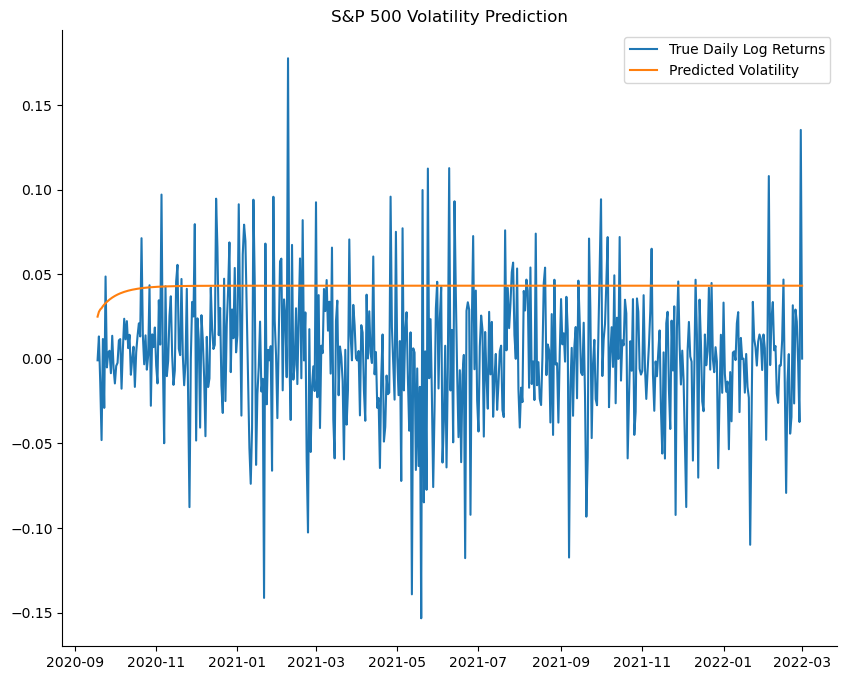

In [25]:
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns
plt.plot(diff_ts[-y_test.shape[0]:])
# Plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

### One-Step Ahead Rolling Forecast

Another suitable and more pragmatic approach would be to only make one-step ahead predictions based on information up until time $t$ and update the information to the model in real time as time $t$ becomes time $t+1$, $t+2$, etc. More simply, with each passing day, we update $X_t$, $X_{t+1}$, $X_{t+2}$ with the actual, observed return from that day to model one time step ahead.

Below, we see how well this rolling volatility prediction is able to capture the volatility in our unseen test data.

In [26]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, vol='GARCH', p=1, q=3, mean='zero', dist='skewt')
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

C:\Users\humic\anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\humic\anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\humic\anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\humic\anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\humic\

Text(0.5, 1.0, 'Bitcoin Rolling Volatility Prediction')

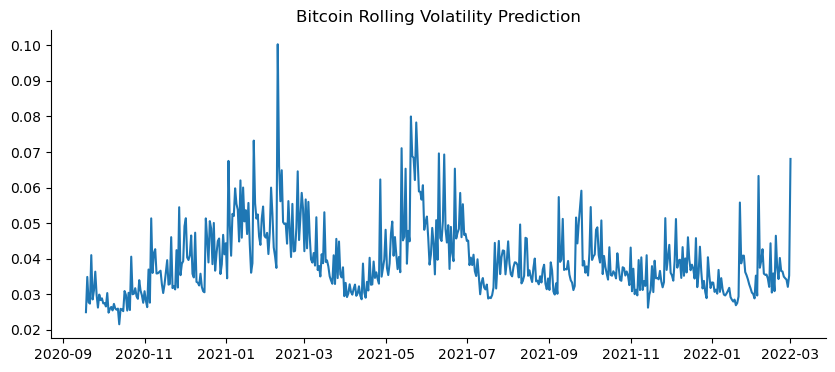

In [27]:
# Plot of predicted test data rolling volatility predictions
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('Bitcoin Rolling Volatility Prediction')

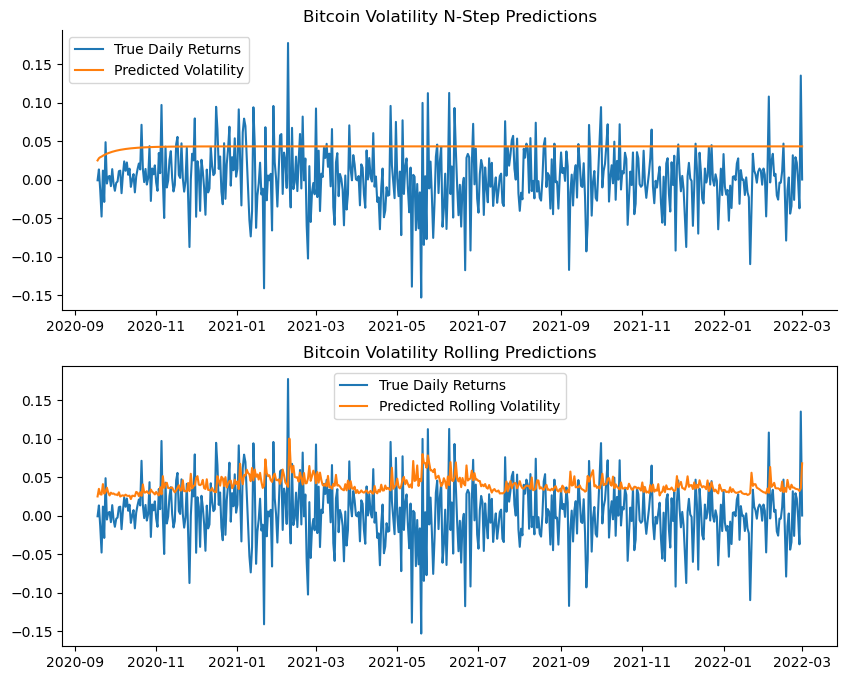

In [28]:
# Compare n-step-ahead and one-step-ahead rolling predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("Bitcoin Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("Bitcoin Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
plt.show()

### Jarque-Bera Test

We make an assumption in the GARCH(P,Q) model about the distribution of our errors: if the model is specified correctly, then the errors are normally distributed with mean 0 and constant variance. The Jarque-Bera test checks if the model errors are normally distributed.

We know that the kurtosis of the normal distribution is 3, which is useful as a reference. If greater than 3, we have a sample that is heavier-tailed than normal distribution. If less than 3, we have a sample that is lighter-tailed than the normal distribution.

We can gather the intuition that using the symmetry and shape of the sample relative to known values for the normal distribution would help us arrive at the following hypothesis:

$H_{0}$: The data has a normal distribution.

$H_{1}$: The data does not have a normal distribution.

In [29]:
# Calculate the standardized residuals on the test data
std_resid = garch_result.resid / garch_result.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 71383.5560152462
p-value: 0.0


The Jarque-Bera test shows us that we do not have standardized residuals that follow the normal distribution. 

## Conclusion

This analysis shows that the bitcoin market is highly volatile. This phenomenon became even more pronounced during the covid pandemic. We therefore conclude that it is difficult to predict the volatility of the bitcoin market.